TEST: Package "Mesa" with Networkx, Travel Model


In [1]:
import networkx as nx

In [2]:
from mesa import Agent, Model
from mesa.time import BaseScheduler
from mesa.datacollection import DataCollector

import numpy as np
import networkx as nx
from random import sample, randrange
import matplotlib.pyplot as plt

### Code for walk on graph

In [13]:
class Travel_Agent(Agent):
    def __init__(self, start_pos, dest, unique_id,model):
        self.pos = start_pos
        self.dest = dest
        self.unique_id = unique_id
        self.model = model
        self.k = 0 # counter for list
        self.path = [9, 10, 187, 37, 36]

    def step(self):
        if self.pos == self.dest:
            return 
        dests = []
        dists = []
        
        # can be dikstra's path
        next_dest=self.path[self.k]

        self.k = self.k + 1
        
        #neighbors = list(self.model.network.neighbors(self.pos))
        #next_dest = np.random.choice(neighbors)
        
        # off you go
        self.pos = next_dest

    def __str__(self):
        templ = "Travel_Agent: {pos: %d, dest: %d, unique_id: %d}" 
        text = templ %(self.pos,self.dest, self.unique_id)
        return text

In [14]:
class Travel_Model(Model):
    def __init__(self, network=None, n_agents=100, max_steps=1000):
        self.n_steps = 0
        self.max_steps = max_steps
        self.schedule = BaseScheduler(self)
        
        if network is None:
            self.network = self._demo_network()
        else:
            self.network = network
                

        # agents
        for n in range(n_agents):
            start, dest = 9, 36
            agent = Travel_Agent(start,dest,n,self)

            self.schedule.add(agent)

        # data collection
        self.dc = DataCollector(
                {
                    "enroute": lambda m: self.count_en_route(m)
                    },
                {
                    "position": lambda a: a.pos
                    }
                )
        self.dc.collect(self)

        self.running = True

    def step(self):
        self.schedule.step()
        self.dc.collect(self)
        self.n_steps +=1

        if self.count_en_route(self) == 0 or self.n_steps >= self.max_steps:
            self.running = False

    def _demo_network(self):
        G=nx.read_shp('/Users/JeroenvanderDoes/Dropbox/Studie/Master/Thesis/Onderwerpen/Programs/QGIS/waterways_amsterdam_bewerkt/edge_data_lengte.shp', simplify=True) # use simplify is true otherwise chart get shifted
        w_G = nx.Graph()
        color_map = []
        lat_lon_to_index = {}
        h = list(G.nodes(data=True)) # in de shapefile nodes are positioned as lonlat instead of latlon

        for i, node in enumerate(G.nodes()): #adds nodes with label 1 till n nodes to the network. 
            w_G.add_node(i, pos= node)
            lat_lon_to_index[node] = i
            color_map.append('r')
    
        for edge in G.edges(data=True): # adds edges with attributes to the graph from shapefile according to the order in which the edges are ordered in the shapefile
            w_G.add_edge(lat_lon_to_index[edge[0]], lat_lon_to_index[edge[1]], dis=edge[2]['cost'] )
    
        return w_G
         

    @staticmethod
    def count_en_route(model):
        count = len(model.schedule.agents)
        for agent in model.schedule.agents:
            if agent.pos == agent.dest:
                count -=1
        return count

In [15]:
travel_model = Travel_Model()
print(travel_model.schedule.agents[56])

Travel_Agent: {pos: 9, dest: 36, unique_id: 56}


In [16]:
travel_model.run_model()
print(travel_model.schedule.agents[56])

Travel_Agent: {pos: 36, dest: 36, unique_id: 56}


In [17]:
df = travel_model.dc.get_agent_vars_dataframe()
path = df.query('AgentID == 56', engine='python')
print(path)

              position
Step AgentID          
0    56              9
1    56              9
2    56             10
3    56            187
4    56             37
5    56             36


In [18]:
path = path['position'].as_matrix()
print(path)
path_edges = [(path[n], path[n+1]) for n in range(len(path)-1)]
#print(path_edges)
g = travel_model.network
pos = nx.get_node_attributes(g, 'pos')


[  9   9  10 187  37  36]


/Users/JeroenvanderDoes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


[]

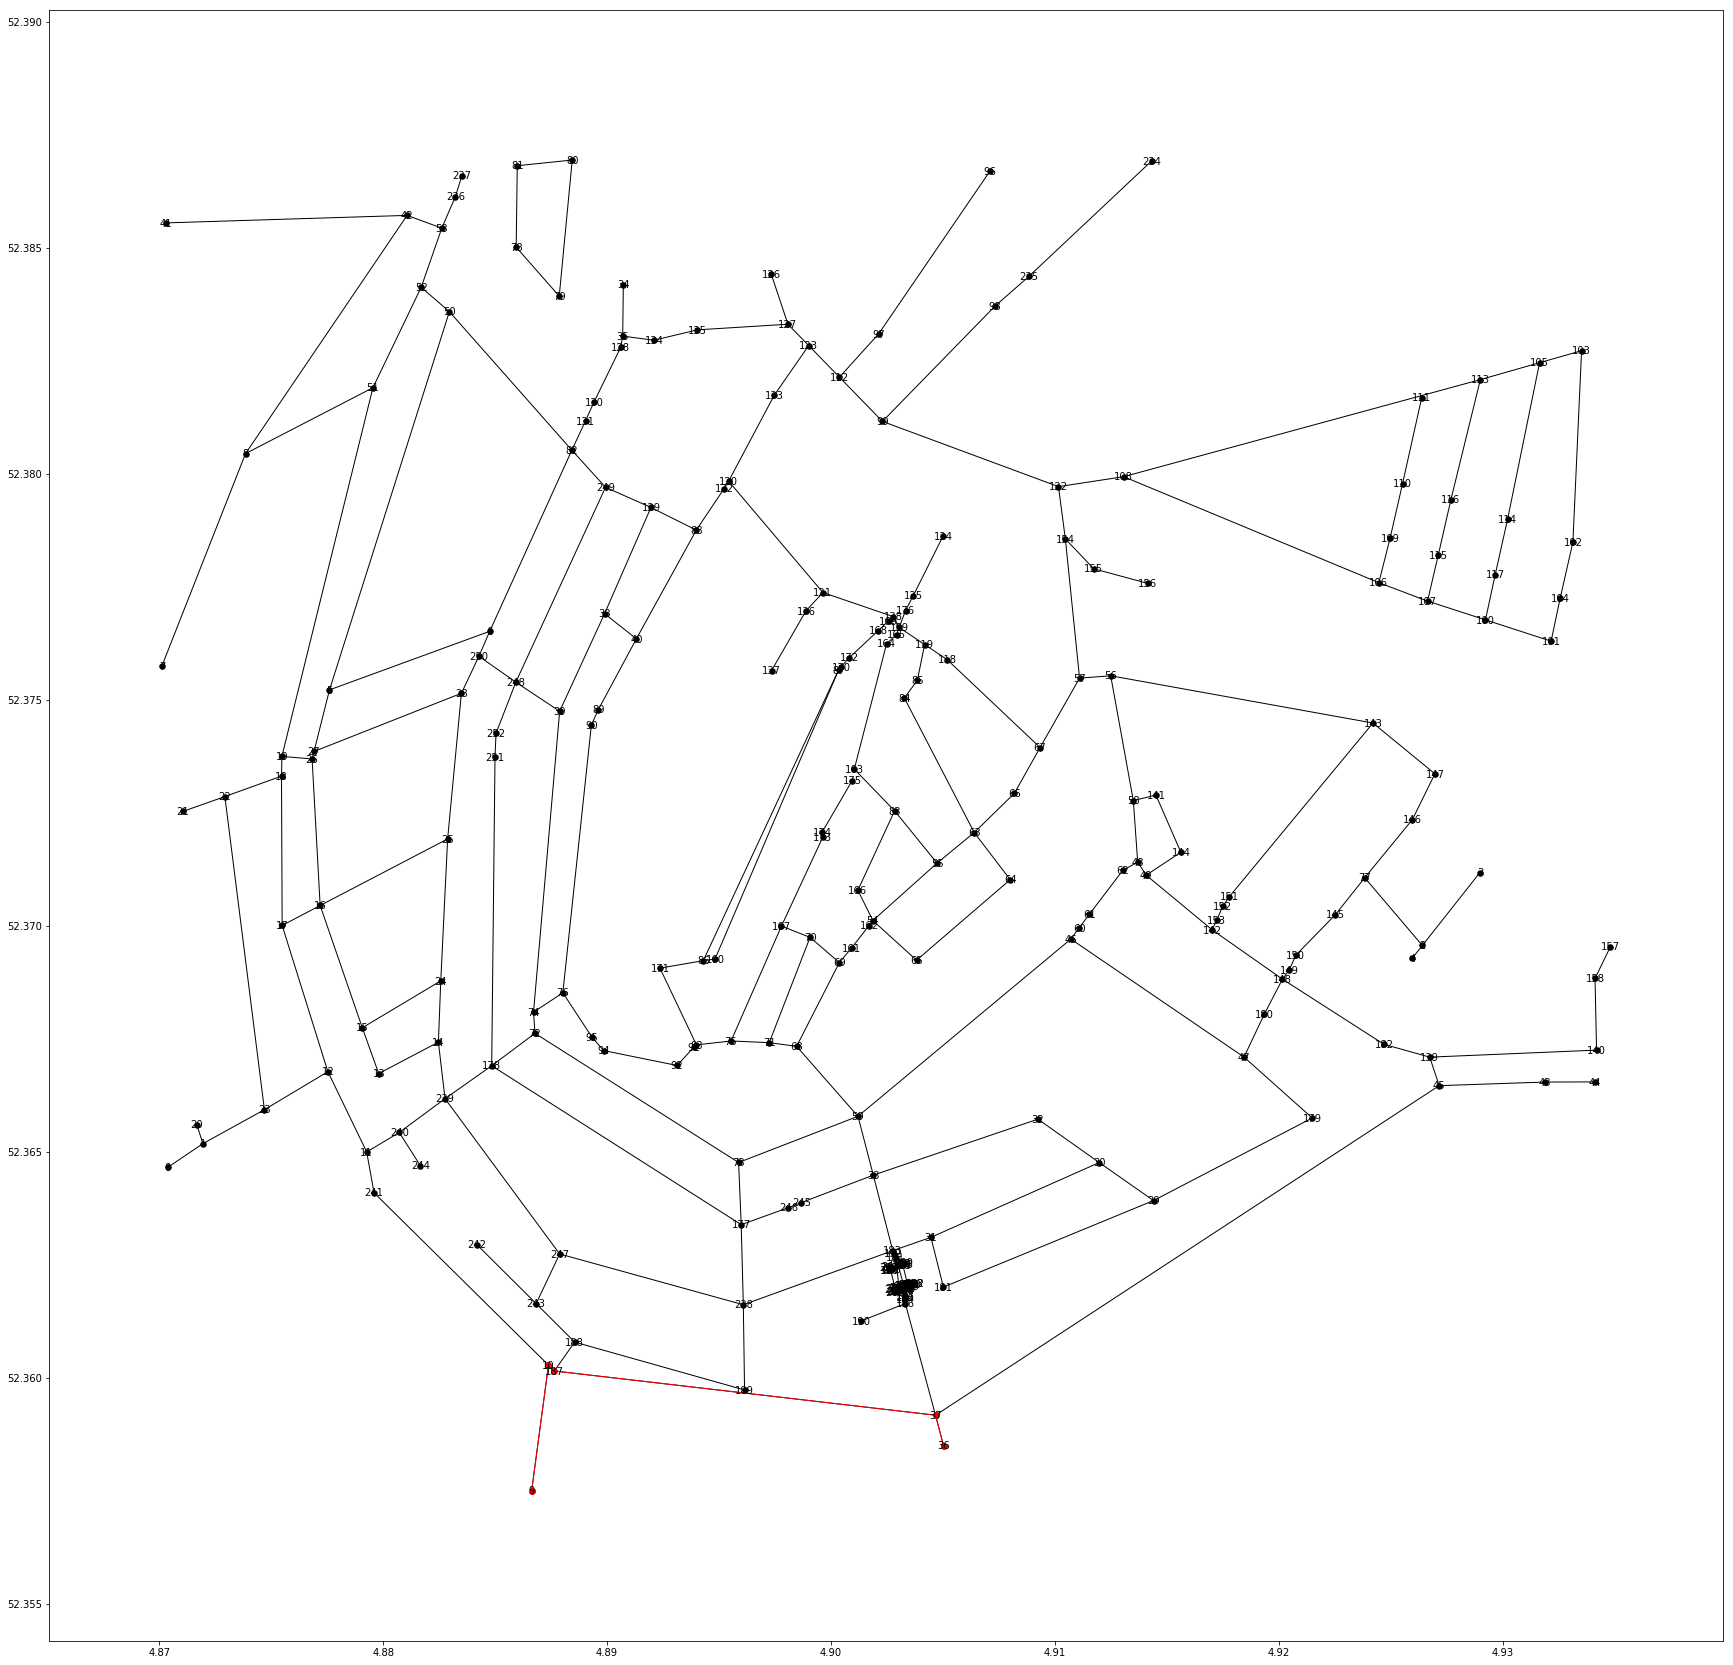

In [19]:
fig = plt.figure(figsize=(30,30))                                   
ax = plt.subplot(111)                               

nx.draw_networkx_nodes(g,pos=pos, node_color='k', node_size=30, labels = True, font_size = 30)
nx.draw_networkx_nodes(g,pos=pos, nodelist=path.tolist(), color='r', node_size=30)
nx.draw_networkx_nodes(g,pos=pos, nodelist=[path[0],path[-1]], color='r', node_size=20)
nx.draw_networkx_edges(g,pos=pos)
nx.draw_networkx_edges(g,pos=pos, edgelist=path_edges, edge_color='r')
nx.draw_networkx_labels(g, pos=pos, font_size = 10)                                  
                               
plt.savefig('/Users/JeroenvanderDoes/Downloads/Amsterdam_Canals_test5.pdf', format='pdf', rasterized=False)
plt.plot()